In [1]:
import sys
sys.path.append('/Users/aimeebarciauskas/Library/Python/3.6/lib/python/site-packages')
sys.path.append('/Users/aimeebarciauskas/Library/Python/3.7/lib/python/site-packages')
sys.path.append('/Users/aimeebarciauskas/Projects/ifsc/')
import psycopg2
import pycountry
import helpers

/Users/aimeebarciauskas/Library/Python/3.6/lib/python/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
query = """
select count(*), athletes.nation as nation, comps.year as year from bouldering_comp_results
  join athletes on athletes.id = bouldering_comp_results.athlete_id
  join comps on bouldering_comp_results.comp_id = comps.id
where bouldering_comp_results.comp_stage = 'semifinal'
group by nation, year
order by nation, year;
"""

countries_semifinals_counts = helpers.raw_fetch(query)
countries_semifinals_counts[0:10]

[(6, 'AUS', 2007),
 (1, 'AUS', 2009),
 (2, 'AUS', 2010),
 (3, 'AUS', 2011),
 (3, 'AUS', 2012),
 (4, 'AUS', 2013),
 (9, 'AUS', 2014),
 (3, 'AUS', 2015),
 (1, 'AUS', 2016),
 (27, 'AUT', 2007)]

In [3]:
query = """
select distinct(athletes.nation) from bouldering_comp_results
  join athletes on athletes.id = bouldering_comp_results.athlete_id
where bouldering_comp_results.comp_stage = 'semifinal';
"""

nations = helpers.format_rows(helpers.raw_fetch(query))
nations

['NED',
 'VEN',
 'USA',
 'SRB',
 'HUN',
 'SUI',
 'AUT',
 'IRL',
 'RUS',
 'ISR',
 'GBR',
 'KAZ',
 'FIN',
 'HKG',
 'BEL',
 'SLO',
 'CZE',
 'GER',
 'LTU',
 'LAT',
 'UKR',
 'POL',
 'SVK',
 'SWE',
 'ESP',
 'BLR',
 'MAS',
 'AUS',
 'FRA',
 'BUL',
 'CHN',
 'CAN',
 'TPE',
 'IRI',
 'KOR',
 'ITA',
 'NOR',
 'JPN',
 'MEX']

In [4]:
# fill in missing years with 0
year_range = range(2007, 2018)
# Verified with https://en.wikipedia.org/wiki/List_of_IOC_country_codes
alternate_keys = {
    'GER': 'Germany', #DEU
    'BUL': 'Bulgaria', #BGR
    'IRI': 'Iran', #IRN
    'LAT': 'Latvia', #LVA
    'MAS': 'Malaysia', #MYS
    'NED': 'Netherlands', #NLD
    'SLO': 'Slovenia', #SVN
    'SUI': 'Switzerland', #CHE?
    'TPE': 'Taipei' # Not listed'
}

def country_year_map(triplet):
    alpha_3 = triplet[1]
    country = alpha_3
    try:
        country = pycountry.countries.get(alpha_3=alpha_3).name
    except KeyError as e:
        #print('Country for 3-letter not found: {0}'.format(alpha_3))
        country = alternate_keys[alpha_3]

    return {
        'count': triplet[0],
        'alpha_3': alpha_3,
        'country': country,
        'year': triplet[2]
    }

def format_key(alpha_3, year):
    return '{0}_{1}'.format(alpha_3, year)

country_count_maps = list(map(country_year_map, countries_semifinals_counts))
country_count_map_of_maps = {format_key(i['alpha_3'], i['year']): i for i in country_count_maps}

for year in year_range:
    for alpha_3 in nations:
        cy_key = format_key(alpha_3, year)
        if cy_key not in country_count_map_of_maps:
            country_count_map_of_maps[cy_key] = country_year_map([0, alpha_3, year])

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import itertools

In [39]:
print(type(country_count_map_of_maps['AUS_2007']['alpha_3']))
print(type(country_count_map_of_maps['AUS_2008']['alpha_3']))

<class 'str'>
<class 'str'>


In [23]:
import pandas as pd

df = pd.DataFrame(country_count_map_of_maps).T
df.head()

,alpha_3,count,country,year
AUS_2007,AUS,6,Australia,2007
AUS_2009,AUS,1,Australia,2009
AUS_2010,AUS,2,Australia,2010
AUS_2011,AUS,3,Australia,2011
AUS_2012,AUS,3,Australia,2012


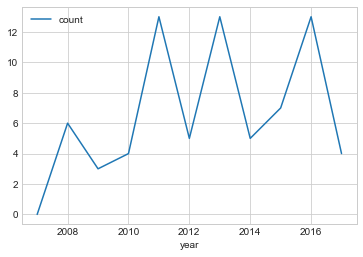

In [55]:
grouped = df.groupby('alpha_3')
usa = grouped.get_group('CAN').sort_values('year')
usa.plot.line(x='year', y='count')

In [62]:
df.groupby('alpha_3').sum().sort_values('count')

,count,country,year
alpha_3,,,
IRL,1,IrelandIrelandIrelandIrelandIrelandIrelandIrel...,22132
HKG,1,Hong KongHong KongHong KongHong KongHong KongH...,22132
BLR,1,BelarusBelarusBelarusBelarusBelarusBelarusBela...,22132
SVK,1,SlovakiaSlovakiaSlovakiaSlovakiaSlovakiaSlovak...,22132
HUN,2,HungaryHungaryHungaryHungaryHungaryHungaryHung...,22132
KAZ,2,KazakhstanKazakhstanKazakhstanKazakhstanKazakh...,22132
VEN,2,"Venezuela, Bolivarian Republic ofVenezuela, Bo...",22132
BUL,2,BulgariaBulgariaBulgariaBulgariaBulgariaBulgar...,22132
MAS,2,MalaysiaMalaysiaMalaysiaMalaysiaMalaysiaMalays...,22132


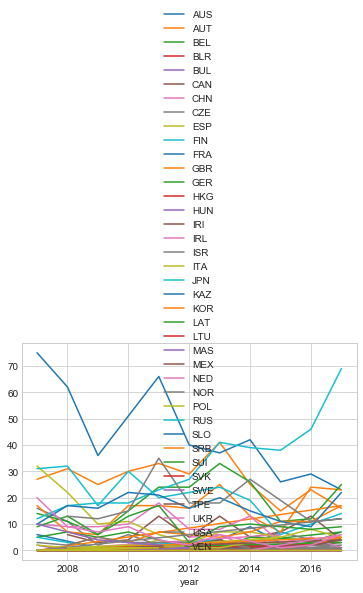

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for key, grp in df.groupby('alpha_3'):
    ax = grp.plot(ax=ax, kind='line', x='year', y='count', label=key)

plt.legend(loc='best')
plt.show()